# `Промышленное машинное обучение на Spark`
## `Занятие 08: Spark Streaming`

### `Находнов Максим (nakhodnov17@gmail.com)`
#### `Москва, 2023`

О чём можно узнать из этого ноутбука:

* Обработка потоковых данных
    * DStream
    * Structured Streaming

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
! pip3 install pyspark pyarrow sparknlp

In [3]:
import os
import time
import glob
from typing import Iterator
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [4]:
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '15g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/19 04:17:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## `DStream`

**Discretized Streams** (или **DStreams**) — это базовая абстракция Spark Streaming для непрерывных потоков данных. Поток может быть входным сигналом, поступающим из источника, или выходными данными, генерируемыми при выполнении преобразований с входным потоком. 

**DStreams — это последовательность RDD.**

Любая операция, применяемая к Потоку, преобразуется в операции с базовым RDD.

### `DStream — поток RDD`

По аналогии со `SparkContext`, которая является *entrypoint* для взаимодействия с кластером, для работы со Streaming функциональностью используется `StreamingContext`. 

Используя `StreamingContext`, можно создавать потоки данных из разных источников. Параметр `batchDuration` определяет промежуток времени за который данные будут с объединены в батч и затем обработаны.

In [5]:
ssc = StreamingContext(sparkContext=sc, batchDuration=2)

Для тестового примера создадим поток RDD из списка RDD:

In [6]:
rdd_queue = []
for idx in range(5):
    rdd_queue += [
        ssc.sparkContext.parallelize(
            [100 * idx + jdx for jdx in range(1, 101)], numSlices=10
        )
    ]
print(f'Число батчей с данными: {len(rdd_queue)}', rdd_queue[0], rdd_queue[0].collect(), sep='\n')

Число батчей с данными: 5
ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [7]:
input_stream = ssc.queueStream(rdd_queue)

Применим `map-reduce` преобразование к потоку данных:

In [8]:
mapped_stream = input_stream.map(lambda x: (x % 10, x))
reduced_stream = mapped_stream.reduceByKey(lambda a, b: a + b)

Вычисления в Spark Streaming являются ленивыми. Нужно отметить, что в качестве **actions**, запускающих вычисления, выступают только операции вывода ([Output Operations](https://spark.apache.org/docs/latest/streaming-programming-guide.html#output-operations-on-dstreams)), которые передают результат вычисления во внешнюю систему (например, выводят в консоль, сохраняют на диск и так далее).

Простейшим примером Output Operations является метод `pprint`, который выводит RDD в консоль:

In [9]:
reduced_stream.pprint()

Однако, вычисления начинаются только в момент, когда данные начинают поступать из внешнего источника. Чтобы запустить приём данных нужно начать "прослушивать" источник данных с помощью метода `start`. 

По умолчанию поток будет продолжать слушать данные бесконечно. Метод `stop` позволяет остановить поток. Однако, если есть необходимость дождаться завершения вычислений, которые буду остановлены *другим потоком*, то можно использовать блокирующий метод `awaitTerminationOrTimeout`.

In [10]:
ssc.start()

# Данный метод выполняет блокировку
# Ожидаем 16 секунд до снятия блокировки
ssc.awaitTerminationOrTimeout(timeout=16)

# Завершаем приём данных в поток
ssc.stop(stopGraceFully=True, stopSparkContext=False)

-------------------------------------------
Time: 2023-04-19 04:17:34
-------------------------------------------
(0, 550)
(1, 460)
(2, 470)
(3, 480)
(4, 490)
(5, 500)
(6, 510)
(7, 520)
(8, 530)
(9, 540)

-------------------------------------------
Time: 2023-04-19 04:17:36
-------------------------------------------
(0, 1550)
(1, 1460)
(2, 1470)
(3, 1480)
(4, 1490)
(5, 1500)
(6, 1510)
(7, 1520)
(8, 1530)
(9, 1540)

-------------------------------------------
Time: 2023-04-19 04:17:38
-------------------------------------------
(0, 2550)
(1, 2460)
(2, 2470)
(3, 2480)
(4, 2490)
(5, 2500)
(6, 2510)
(7, 2520)
(8, 2530)
(9, 2540)

-------------------------------------------
Time: 2023-04-19 04:17:40
-------------------------------------------
(0, 3550)
(1, 3460)
(2, 3470)
(3, 3480)
(4, 3490)
(5, 3500)
(6, 3510)
(7, 3520)
(8, 3530)
(9, 3540)

-------------------------------------------
Time: 2023-04-19 04:17:42
-------------------------------------------
(0, 4550)
(1, 4460)
(2, 4470)
(3, 44

### `Чтение из сокета`

Другой способ получения данных в поток — считывание из сокета:

In [11]:
ssc = StreamingContext(sparkContext=sc, batchDuration=3)

dstream = ssc.socketTextStream('localhost', 9999)
dstream

In [12]:
dstream.pprint()

Запустим клиент, который будет отправлять данные в поток:
```bash
nc -l 9999
```

In [13]:
ssc.start()

-------------------------------------------
Time: 2023-04-19 04:18:30
-------------------------------------------

-------------------------------------------
Time: 2023-04-19 04:18:33
-------------------------------------------

23/04/19 04:18:33 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:18:33 WARN BlockManager: Block input-0-1681867113600 replicated to only 0 peer(s) instead of 1 peers
23/04/19 04:18:35 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:18:35 WARN BlockManager: Block input-0-1681867115400 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:18:36
-------------------------------------------
dog cat apple
cat



23/04/19 04:18:37 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:18:37 WARN BlockManager: Block input-0-1681867116800 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:18:39
-------------------------------------------
dog



23/04/19 04:18:40 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:18:40 WARN BlockManager: Block input-0-1681867120000 replicated to only 0 peer(s) instead of 1 peers
23/04/19 04:18:41 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:18:41 WARN BlockManager: Block input-0-1681867121600 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:18:42
-------------------------------------------
cat cat 
dog



-------------------------------------------
Time: 2023-04-19 04:18:45
-------------------------------------------

-------------------------------------------
Time: 2023-04-19 04:18:48
-------------------------------------------



In [14]:
ssc.stop(stopGraceFully=False, stopSparkContext=False)

23/04/19 04:18:49 WARN SocketReceiver: Error receiving data
java.net.SocketException: Socket closed
	at java.base/sun.nio.ch.NioSocketImpl.endRead(NioSocketImpl.java:238)
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:317)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:340)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:789)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:1025)
	at java.base/sun.nio.cs.StreamDecoder.readBytes(StreamDecoder.java:333)
	at java.base/sun.nio.cs.StreamDecoder.implRead(StreamDecoder.java:376)
	at java.base/sun.nio.cs.StreamDecoder.lockedRead(StreamDecoder.java:219)
	at java.base/sun.nio.cs.StreamDecoder.read(StreamDecoder.java:173)
	at java.base/java.io.InputStreamReader.read(InputStreamReader.java:189)
	at java.base/java.io.BufferedReader.fill(BufferedReader.java:161)
	at java.base/java.io.BufferedReader.implReadLine(BufferedReader.java:371)
	at java.base/java.io.BufferedReader.readLine(

Exception in thread "receiver-supervisor-future-0" java.lang.InterruptedException: sleep interrupted
	at java.base/java.lang.Thread.sleep0(Native Method)
	at java.base/java.lang.Thread.sleep(Thread.java:465)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor

### `Word Count`

Реализуем Word Count на потоковых данных:

In [15]:
ssc = StreamingContext(sparkContext=sc, batchDuration=10)

lines = ssc.socketTextStream('localhost', 9999)
words = lines.flatMap(lambda line: line.split(' '))
pairs = words.map(lambda word: (word, 1))
counts = pairs.reduceByKey(lambda x, y: x + y)

counts.pprint()

In [16]:
ssc.start()

23/04/19 04:19:18 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:19:18 WARN BlockManager: Block input-0-1681867158600 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:19:20
-------------------------------------------
('cat', 2)
('duck', 1)
('dog', 1)



23/04/19 04:19:22 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:19:22 WARN BlockManager: Block input-0-1681867162200 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:19:30
-------------------------------------------
('dog', 1)



23/04/19 04:19:36 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:19:36 WARN BlockManager: Block input-0-1681867175800 replicated to only 0 peer(s) instead of 1 peers
23/04/19 04:19:37 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:19:37 WARN BlockManager: Block input-0-1681867177200 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:19:40
-------------------------------------------
('cat', 2)
('apple', 2)



-------------------------------------------
Time: 2023-04-19 04:19:50
-------------------------------------------



23/04/19 04:19:59 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/04/19 04:19:59 WARN BlockManager: Block input-0-1681867199400 replicated to only 0 peer(s) instead of 1 peers


-------------------------------------------
Time: 2023-04-19 04:20:00
-------------------------------------------
('hello', 1)



In [17]:
ssc.stop(stopGraceFully=False, stopSparkContext=False)

23/04/19 04:20:04 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver
23/04/19 04:20:04 WARN SocketReceiver: Error receiving data
java.net.SocketException: Socket closed
	at java.base/sun.nio.ch.NioSocketImpl.endRead(NioSocketImpl.java:238)
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:317)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:340)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:789)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:1025)
	at java.base/sun.nio.cs.StreamDecoder.readBytes(StreamDecoder.java:333)
	at java.base/sun.nio.cs.StreamDecoder.implRead(StreamDecoder.java:376)
	at java.base/sun.nio.cs.StreamDecoder.lockedRead(StreamDecoder.java:219)
	at java.base/sun.nio.cs.StreamDecoder.read(StreamDecoder.java:173)
	at java.base/java.io.InputStreamReader.read(InputStreamReader.java:189)
	at java.base/java.io.BufferedReader.fill(BufferedReader.java:161)
	at java.base/java.io.Buff

Exception in thread "receiver-supervisor-future-0" java.lang.InterruptedException: sleep interrupted
	at java.base/java.lang.Thread.sleep0(Native Method)
	at java.base/java.lang.Thread.sleep(Thread.java:465)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor

### `Online Learning`

Благодаря обработке данных отдельными батчами DStream отлично подходит для online обучения ML алгоритмов.

Попробуем обучить **KMeans** на потоковых данных. В частности, кластеризуем изображения цифр в разрешении $8\times 8$:

In [18]:
import numpy as np

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
low_d_data = TSNE(n_components=2, init='pca', learning_rate=200.0).fit_transform(data)

idxs = np.arange(len(labels))

(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f'Число классов: {n_digits}; число объектов: {n_samples}; число признаков {n_features}')

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Число классов: 10; число объектов: 1797; число признаков 64


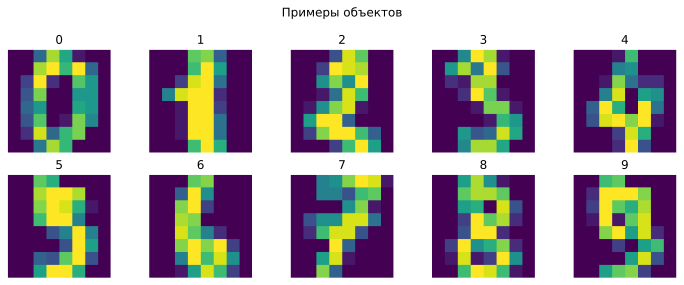

In [19]:
grid_size = np.array([2, 5])
fig, axes = plt.subplots(*grid_size, figsize=2 * grid_size[::-1])

for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(data[idx].reshape(8, 8))
    ax.set_title(labels[idx])
    ax.set_axis_off()
    
fig.suptitle('Примеры объектов')
fig.tight_layout()
plt.show()

Для потокового машинного обучения используется модуль **MLLib**:

In [20]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import StreamingKMeans

Сгенерируем поток данных из нашей выборки:

In [21]:
ssc = StreamingContext(sparkContext=sc, batchDuration=0.001)

batch_size = 64
num_batches = 10 * len(data) // batch_size
random_generator = np.random.default_rng(43)

rdds = []
for idx in range(num_batches):
    batch_idxs = random_generator.choice(len(data), size=batch_size, replace=False)
    rdds.append(
        ssc.sparkContext.parallelize(
            list(zip(idxs[batch_idxs], labels[batch_idxs], data[batch_idxs])), numSlices=2
        )
    )
    
print(f'Число батчей с данными: {len(rdds)}\n', sep='\n')
print(rdds[0], f'Число элементов в батче: {len(rdds[0].collect())}\n', sep='\n')
print('Несколько элементов из батча:', rdds[0].collect()[:4], sep='\n')

Число батчей с данными: 280

ParallelCollectionRDD[145] at readRDDFromFile at PythonRDD.scala:274
Число элементов в батче: 64

Несколько элементов из батча:
[(1515, 4, array([ 0.,  0.,  0., 14.,  8.,  0.,  0.,  0.,  0.,  0.,  3., 16.,  3.,
        0.,  0.,  0.,  0.,  0., 12.,  9.,  9.,  7.,  0.,  0.,  0.,  6.,
       15.,  1., 14., 11.,  6.,  0.,  0., 13., 14.,  8., 16., 16.,  7.,
        0.,  0.,  8., 16., 16., 16.,  3.,  0.,  0.,  0.,  0.,  1., 11.,
       14.,  0.,  0.,  0.,  0.,  0.,  0., 14., 14.,  0.,  0.,  0.])), (1464, 0, array([ 0.,  0.,  3., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 14., 15.,
       13.,  0.,  0.,  0.,  2., 14.,  1.,  2., 13.,  4.,  0.,  0.,  4.,
        8.,  0.,  0.,  5.,  8.,  0.,  0.,  4.,  8.,  0.,  0.,  4.,  8.,
        0.,  0.,  4., 10.,  0.,  0.,  5.,  8.,  0.,  0.,  0., 14., 11.,
       10., 14.,  5.,  0.,  0.,  0.,  4., 12., 13.,  9.,  0.,  0.])), (1662, 9, array([ 0.,  0.,  7., 15., 16., 12.,  0.,  0.,  0., 12., 16., 11., 16.,
       13.,  0.,  0.,  0

In [22]:
data_stream = ssc.queueStream(rdds)
data_stream

Подготовим данные перед подачей на вход алгоритму. Для этого нужно преобразовать массив признаков в `Vector`:

In [23]:
vectors_stream = data_stream.map(lambda x: ((x[0], x[1]), Vectors.dense(x[2])))

Определим пайплан для обучения и функцию, которая будет выполнять предсказания на данном батче, используя текущую модель:

In [24]:
kmeans = (
    StreamingKMeans()
        .setK(10)
        .setDecayFactor(0.9)
        .setRandomCenters(64, weight=0.5, seed=42)
)
kmeans.trainOn(vectors_stream.map(lambda x: x[1]))

predictions = kmeans.predictOnValues(vectors_stream)
predictions.saveAsTextFiles(prefix='./kmeans-predictions/batch', suffix='txt')

In [25]:
! rm -rf ./kmeans-predictions/
ssc.start()

# Завершим обучение через 200 секунд, предполагая, что за это время модель успеет обработать все данные
# В общем случае должен использоваться более сложный критерий остановки, который вызовет метод stop
ssc.awaitTerminationOrTimeout(timeout=200)
ssc.stop(stopGraceFully=False, stopSparkContext=False)

23/04/19 04:20:57 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


23/04/19 04:24:17 ERROR SparkHadoopWriter: Aborting job job_202304190424174977096642835434695_12473.
java.lang.InterruptedException
	at java.base/java.util.concurrent.locks.AbstractQueuedSynchronizer.acquireSharedInterruptibly(AbstractQueuedSynchronizer.java:1048)
	at scala.concurrent.impl.Promise$DefaultPromise.tryAwait(Promise.scala:242)
	at scala.concurrent.impl.Promise$DefaultPromise.ready(Promise.scala:258)
	at scala.concurrent.impl.Promise$DefaultPromise.ready(Promise.scala:187)
	at org.apache.spark.util.ThreadUtils$.awaitReady(ThreadUtils.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:943)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2281)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:83)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairR

In [26]:
def plot_2d_data(data, labels, title='Исходные данные', cmap='tab20', ax=None):
    '''
    Отрисовка 2d scatter plot. 
    :param np.ndarray data: 2d массив точек
    :param Union[list, np.ndarray] labels: список меток для каждой точки выборки
    :param str title: Заголовок графика
    :param str cmap: Цветовая палитра
    :param ax Optional[matplotlib.axes.Axes]: Оси для отрисовки графика.
        Если оси не заданы, то создаётся новая фигура и сразу же происходит её отрисовка
        Иначе, график добавляется на существующие оси. Отрисовки фигуры не происходит
    '''
    unique_labels, labels_inv = np.unique(labels, return_inverse=True)
    n_clusters = len(unique_labels)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig = None
        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels_inv, 
        cmap=plt.get_cmap(cmap, n_clusters)
    )

    cbar = plt.colorbar(scatter, label='Номер кластера', ax=ax)
    cbar.set_ticks((np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(unique_labels)
    
    ax.set_title(title)
    ax.grid(True)
    
    if fig is not None:
        fig.tight_layout()
        plt.show()

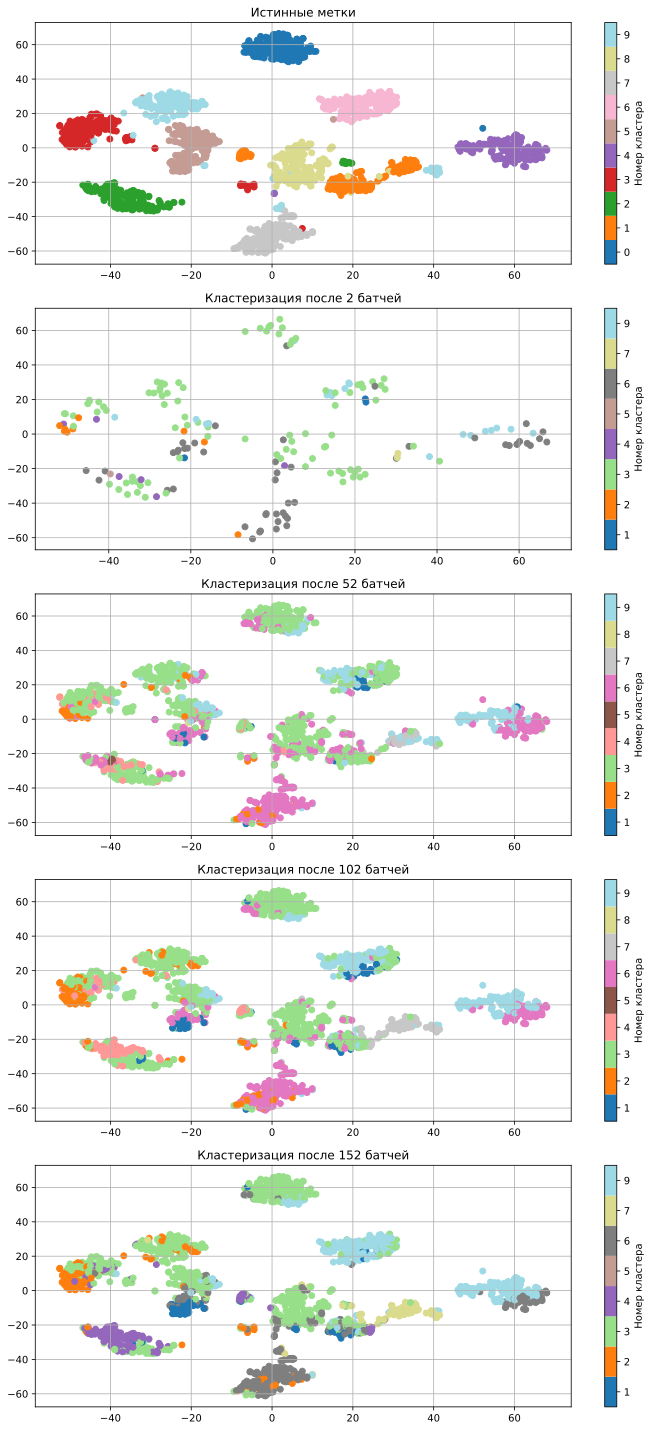

In [27]:
batch_files = sorted(os.listdir('./kmeans-predictions/'))

grid_size = np.array([5, 1])
fig, axes = plt.subplots(*grid_size, figsize=np.array([10, 4]) * grid_size[::-1])

plot_2d_data(low_d_data, labels, ax=axes[0], title='Истинные метки')

ax_idx = 0
predictions = -np.ones_like(labels)
for ts, batch_predictions_path in enumerate(batch_files):
    for path in glob.glob(os.path.join('./kmeans-predictions/', batch_predictions_path, '*')):
        if os.path.isfile(path) and not path.endswith('_SUCCESS'):
            with open(path, 'r') as file:
                for line in file:
                    ((idx, label), cluster) = eval(line)
                    predictions[idx] = cluster                    
             
    if ts % 50 == 2:
        ax_idx += 1
        if ax_idx == len(axes):
            break   
            
        plot_2d_data(
            low_d_data[predictions != -1], predictions[predictions != -1], 
            title=f'Кластеризация после {ts} батчей', ax=axes[ax_idx]
        )
            
fig.tight_layout()
plt.show()

## `Structured Streaming`

Spark Streaming — достаточно низкоуровневый, преимущественно *stateless* подход к потоковой обработке данных. Современной альтернативой является **Structured Streaming**. Эта библиотека занимает такое же место по отношению к Spark Streaming, как DataFrame API к RDD API.

Structured Streaming позволяет работать с потоками данных таким же образом как и с таблицами фиксированного размера. В этой парадигме поток данных представлен бесконечной таблицей. При этом вычисления над таким потоком-бесконечной таблицей происходят по триггеру в определённые моменты времени. Заметим, что в фиксированный момент времени необходимо обрабатывать только конечную таблицу. Structured Streaming позволяет выполнять запросы к бесконечным таблицам за счёт эффективного обновления внутреннего состояния при переходе от одного момента времени к другому. 

Рассмотрим пример Word Count с использованием Structured Streaming.

Создадим таблицу, которая использует сокет в качества источника данных:

In [28]:
lines = (
    spark
        .readStream
        .format('socket')
        .option('host', 'localhost')
        .option('port', 9999)
        .load()
)
lines

23/04/19 04:25:35 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


DataFrame[value: string]

In [29]:
words = lines.select(
   F.explode(
       F.split(lines.value, ' ')
   ).alias('word')
)

counts = words.groupBy('word').count()

In [30]:
counts.explain(extended=True)

counts.schema

== Parsed Logical Plan ==
'Aggregate ['word], ['word, count(1) AS count#7L]
+- Project [word#3]
   +- Generate explode(split(value#0,  , -1)), false, [word#3]
      +- StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.TextSocketSourceProvider@7f8d77f8, socket, org.apache.spark.sql.execution.streaming.sources.TextSocketTable@42eaa7c1, [host=localhost, port=9999], [value#0]

== Analyzed Logical Plan ==
word: string, count: bigint
Aggregate [word#3], [word#3, count(1) AS count#7L]
+- Project [word#3]
   +- Generate explode(split(value#0,  , -1)), false, [word#3]
      +- StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.TextSocketSourceProvider@7f8d77f8, socket, org.apache.spark.sql.execution.streaming.sources.TextSocketTable@42eaa7c1, [host=localhost, port=9999], [value#0]

== Optimized Logical Plan ==
Aggregate [word#3], [word#3, count(1) AS count#7L]
+- Generate explode(split(value#0,  , -1)), [0], false, [word#3]
   +- StreamingRelationV2 org.apac

StructType([StructField('word', StringType(), False), StructField('count', LongType(), False)])

Также как и в Spark Streaming в качества actions выступают операции вывода информации.

При этом существуют разные [режимы вывода](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-modes): 
* **Complete mode** — выводится всё содержимое таблицы-результата
* **Append mode** — выводятся только новые строки в таблице-результате
* **Update mode** — выводятся только те строки, которые обновились в таблице-результате

Нужно учитывать, что не все режимы вывода совместимы со всем трансформациями в графе вычислений.

В данном примере будем выводить результирующую таблицу в режиме *update* в каждый момент срабатывания триггера:

In [31]:
query = (
    counts
        .writeStream
        .outputMode('update')
        .format('console')
).start()

23/04/19 04:26:00 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-ffa55a2f-c391-4458-9cd5-7a4d9fe135da. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:26:00 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
| dog|    2|
| cat|    1|
+----+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|apple|    1|
+-----+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
| dog|    3|
+----+-----+



-------------------------------------------
Batch: 4
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|apple|    2|
|  cat|    2|
+-----+-----+



In [32]:
query.stop()

Рассмотрим пример с таблицей, которая зачитывается с жёсткого диска.

Будем использовать датасет с данными с носимых устройств [Heterogeneity Activity Recognition Data Set](http://archive.ics.uci.edu/ml/datasets/heterogeneity+activity+recognition):

In [33]:
! rm -rf './Activity recognition exp.zip' './activity-data'
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip
! unzip -j './Activity recognition exp.zip' 'Activity recognition exp/*' -d activity-data

--2023-04-19 04:26:43--  http://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 777127275 (741M) [application/x-httpd-php]
Сохранение в: «Activity recognition exp.zip»

Activity recognitio 100%[===================>] 741,13M  15,5MB/s    за 49s     

2023-04-19 04:27:33 (15,2 MB/s) - «Activity recognition exp.zip» сохранён [777127275/777127275]

Archive:  ./Activity recognition exp.zip
  inflating: activity-data/.DS_Store  
  inflating: activity-data/Phones_accelerometer.csv  
  inflating: activity-data/Phones_gyroscope.csv  
  inflating: activity-data/readme.txt  
  inflating: activity-data/Watch_accelerometer.csv  
  inflating: activity-data/Watch_gyroscope.csv  


Сначала посмотрим на часть этих данных в виде статической таблицы:

In [34]:
static_df = (
    spark
        .read
        .option('inferSchema', True)
        .option('header', True)
        .csv('activity-data/Phones_accelerometer.csv')
)
static_df.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- User: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- gt: string (nullable = true)



In [35]:
static_df.sample(5e-7, seed=43).toPandas()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,14545,1424696715942,1424698561997492480,-5.673569,0.548065,7.885208,a,nexus4,nexus4_2,stand
1,131383,1424786822190,12492202466000,-1.838724,-2.298405,9.346847,b,samsungold,samsungold_1,bike
2,66140,1424699889452,55541427398000,-3.189077,-1.493982,9.136273,h,s3,s3_1,walk


Теперь представим данные в виде потока. Spark умеет зачитывать новые файлы из указанной директории и обрабатывать их в потоковом режиме:

In [36]:
streaming_df = (
    spark
        .readStream
        .schema(static_df.schema)
        .option('header', True)
        .option('maxFilesPerTrigger', 1)
        .csv('./activity-data/*.csv')
)

Сделаем запрос, который будет подсчитывать число событий указанного типа к данному моменту времени:

In [37]:
activity_counts = streaming_df.groupBy('gt').count()

In [38]:
activity_query = (
    activity_counts
        .writeStream
        .queryName('activity_counts')
        .format('console')
        .outputMode('complete')
        .start()
)

23/04/19 04:28:51 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-16610031-a6ab-4b11-9b9a-deddf9dc9072. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:28:51 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|1782010|
|       sit|1991919|
|     stand|1851492|
|      walk|2192401|
|      bike|1845557|
|stairsdown|1615896|
|      null|1783200|
+----------+-------+



-------------------------------------------
Batch: 1
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|3666316|
|       sit|4210420|
|     stand|3875698|
|      walk|4542830|
|      bike|3757287|
|stairsdown|3289729|
|      null|3652827|
+----------+-------+



-------------------------------------------
Batch: 2
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|4140070|
|       sit|4634415|
|     stand|4326887|
|      walk|5092591|
|      bike|4392817|
|stairsdown|3776105|
|      null|4173184|
+----------+-------+



-------------------------------------------
Batch: 3
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|4586093|
|       sit|5053949|
|     stand|4757110|
|      walk|5580900|
|      bike|4915489|
|stairsdown|4204346|
|      null|4643613|
+----------+-------+



In [39]:
activity_query.stop()

Сравним вывод в случае других методов вывода:

In [40]:
! head ./activity-data/Phones_accelerometer.csv > ./activity-data/Sample_data.csv

activity_query = (
    activity_counts
        .writeStream
        .trigger(processingTime='1 seconds')
        .format('console')
        .outputMode('update')
        .start()
)

23/04/19 04:29:40 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-02b98d59-e273-4299-b3a0-40f44ab9c05b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:29:40 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|1782010|
|       sit|1991919|
|     stand|1851492|
|      walk|2192401|
|      bike|1845557|
|stairsdown|1615896|
|      null|1783200|
+----------+-------+

23/04/19 04:29:47 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 6911 milliseconds


-------------------------------------------
Batch: 1
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|3666316|
|       sit|4210420|
|     stand|3875698|
|      walk|4542830|
|      bike|3757287|
|stairsdown|3289729|
|      null|3652827|
+----------+-------+

23/04/19 04:29:54 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 6807 milliseconds


-------------------------------------------
Batch: 2
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|4140070|
|       sit|4634415|
|     stand|4326887|
|      walk|5092591|
|      bike|4392817|
|stairsdown|3776105|
|      null|4173184|
+----------+-------+

23/04/19 04:29:57 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 3668 milliseconds


-------------------------------------------
Batch: 3
-------------------------------------------
+----------+-------+
|        gt|  count|
+----------+-------+
|  stairsup|4586093|
|       sit|5053949|
|     stand|4757110|
|      walk|5580900|
|      bike|4915489|
|stairsdown|4204346|
|      null|4643613|
+----------+-------+

23/04/19 04:30:01 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 3866 milliseconds


-------------------------------------------
Batch: 4
-------------------------------------------
+-----+-------+
|   gt|  count|
+-----+-------+
|stand|4757119|
+-----+-------+

23/04/19 04:30:04 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 2769 milliseconds


In [41]:
activity_query.stop()

! rm ./activity-data/Sample_data.csv

Из семантики запроса очевидно, что метод *append* нельзя использовать:

In [42]:
activity_query = (
    activity_counts
        .writeStream
        .trigger(processingTime='5 seconds')
        .format('console')
        .outputMode('append')
        .start()
)

23/04/19 04:30:40 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-5f38790d-0a7e-4954-b8d2-74ed0e71c4b2. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:30:40 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


AnalysisException: Append output mode not supported when there are streaming aggregations on streaming DataFrames/DataSets without watermark;
Aggregate [gt#140], [gt#140, count(1) AS count#162L]
+- StreamingRelation DataSource(org.apache.spark.sql.SparkSession@4270e196,csv,List(),Some(StructType(StructField(Index,IntegerType,true),StructField(Arrival_Time,LongType,true),StructField(Creation_Time,LongType,true),StructField(x,DoubleType,true),StructField(y,DoubleType,true),StructField(z,DoubleType,true),StructField(User,StringType,true),StructField(Model,StringType,true),StructField(Device,StringType,true),StructField(gt,StringType,true))),List(),None,Map(header -> true, maxFilesPerTrigger -> 1, path -> ./activity-data/*.csv),None), FileSource[./activity-data/*.csv], [Index#131, Arrival_Time#132L, Creation_Time#133L, x#134, y#135, z#136, User#137, Model#138, Device#139, gt#140]


Посмотрим на пример с использованием агрегации. Посчитаем средние координаты в разрезе *тип события*-*модель телефона*:

In [43]:
gt_model_stats = (
    streaming_df.cube('gt', 'model').avg()
        .drop('avg(Arrival_time)')
        .drop('avg(Creation_Time)')
        .drop('avg(Index)')
    
        .writeStream
        .queryName('device_counts')
        .format('console')
        .outputMode('complete')
        .start()
)

23/04/19 04:30:51 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-93801195-0bbe-4851-aec9-dc707b768e40. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:30:51 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----------+----------+--------------------+--------------------+-----------------+
|        gt|     model|              avg(x)|              avg(y)|           avg(z)|
+----------+----------+--------------------+--------------------+-----------------+
|      bike|    s3mini|-0.38061769919708743|0.015550321028655768|8.945381420138668|
|      walk|samsungold| -2.3167542069691107| 0.06237284777548883|9.090278628404171|
|      walk|        s3|  -3.495150568759322|   0.301391345434463|8.796797834500957|
|      bike|        s3| -1.8009422106912851| 0.11803867707238379|9.114031867730652|
|      walk|    s3mini| -1.7422817610295747| 0.41736026278008376|8.573763014336322|
|      null|    nexus4| -1.8586523317319017|0.054771997676446874|9.159500096729216|
|      null|      null|   -2.40158496305421| 0.20022131768024148|  9.0623753663004|
|stairsdown|      null| -3.2161605003870792| 0.1986353512584507

-------------------------------------------
Batch: 1
-------------------------------------------
+----------+----------+--------------------+--------------------+------------------+
|        gt|     model|              avg(x)|              avg(y)|            avg(z)|
+----------+----------+--------------------+--------------------+------------------+
|      bike|    s3mini|-0.19837130254160404|0.001546135208933...|     4.42881098178|
|      walk|samsungold| -2.3167542069691107| 0.06237284777548883| 9.090278628404171|
|      walk|        s3| -1.1458182577701403| 0.09575613213690089|2.8982692639179626|
|      bike|        s3| -0.5670091984048415|0.026292487375285806|2.9350489084608227|
|      walk|    s3mini| -0.8785738034832212| 0.20424418822168142| 4.282380956783724|
|      null|    nexus4| -0.9290848232433098| 0.02437835288521938| 4.574675281721481|
|      null|      null| -1.1753280737508967| 0.09529860501020959| 4.427294503327655|
|stairsdown|      null| -1.5699935480938507| 0.080499

-------------------------------------------
Batch: 2
-------------------------------------------
+----------+----------+--------------------+--------------------+------------------+
|        gt|     model|              avg(x)|              avg(y)|            avg(z)|
+----------+----------+--------------------+--------------------+------------------+
|      null|      gear|  1.7459231757426479|  -2.695190482909125|0.7139552277715246|
|      bike|    s3mini|-0.19837130254160404|0.001546135208933...|     4.42881098178|
|      walk|      gear|  2.7385755516396473| -1.9025932893487132|0.2146451901940084|
|      walk|samsungold| -2.3167542069691107| 0.06237284777548883| 9.090278628404171|
|      walk|        s3| -1.1458182577701403| 0.09575613213690089|2.8982692639179626|
|      bike|        s3| -0.5670091984048415|0.026292487375285806|2.9350489084608227|
|      walk|    s3mini| -0.8785738034832212| 0.20424418822168142| 4.282380956783724|
|      null|    nexus4| -0.9290848232433098| 0.024378

-------------------------------------------
Batch: 3
-------------------------------------------
+----------+----------+--------------------+--------------------+-------------------+
|        gt|     model|              avg(x)|              avg(y)|             avg(z)|
+----------+----------+--------------------+--------------------+-------------------+
|      null|      gear|  0.8824431859818217|  -1.361013293007187| 0.3398790604465807|
|      bike|    s3mini|-0.19837130254160404|0.001546135208933...|      4.42881098178|
|      walk|      gear|  1.3899624236035701| -0.9651043552168403|0.07708815336821917|
|      walk|samsungold| -2.3167542069691107| 0.06237284777548883|  9.090278628404171|
|      walk|        s3| -1.1458182577701403| 0.09575613213690089| 2.8982692639179626|
|      bike|        s3| -0.5670091984048415|0.026292487375285806| 2.9350489084608227|
|      walk|    s3mini| -0.8785738034832212| 0.20424418822168142|  4.282380956783724|
|      null|    nexus4| -0.9290848232433098

In [44]:
gt_model_stats.stop()

Теперь посмотрим, как работать с временами событий: 

In [45]:
with_event_time_df = streaming_df.select(
    '*',
    (F.col('Creation_Time').cast(T.DoubleType()) / F.lit(1e9))
        .cast(T.TimestampType())
        .alias('event_time')
)

Посчитаем число событий внутри десятиминутных интервалов:

In [46]:
window_count_query = (
    with_event_time_df
        .groupBy(F.window(F.col('event_time'), '10 minutes'))
        .count()
    
        .writeStream
        .format('console')
        .option('truncate', 'false')
        .outputMode('complete')
        .start()
)

23/04/19 04:31:44 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-6fd452b9-c3b6-4fb4-8a59-591562b41a2b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:31:44 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{1970-01-05 04:20:00, 1970-01-05 04:30:00}|56451 |
|{2015-02-23 13:10:00, 2015-02-23 13:20:00}|11514 |
|{1970-01-04 08:10:00, 1970-01-04 08:20:00}|70376 |
|{1970-01-05 04:40:00, 1970-01-05 04:50:00}|33064 |
|{1970-01-05 04:30:00, 1970-01-05 04:40:00}|56204 |
|{1970-01-04 08:50:00, 1970-01-04 09:00:00}|21153 |
|{1970-01-05 03:00:00, 1970-01-05 03:10:00}|56278 |
|{1970-01-01 07:50:00, 1970-01-01 08:00:00}|57311 |
|{1970-01-01 04:40:00, 1970-01-01 04:50:00}|169130|
|{1970-01-04 10:00:00, 1970-01-04 10:10:00}|22687 |
|{1970-01-05 02:50:00, 1970-01-05 03:00:00}|57266 |
|{1970-01-04 07:20:00, 1970-01-04 07:30:00}|56995 |
|{1970-01-05 05:00:00, 1970-01-05 05:10:00}|55531 |
|{1970-01-02 18:20:00, 1970-01-02 18:30:00}|57894 |
|{2015-02-24 16:00:

-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{1970-01-05 04:20:00, 1970-01-05 04:30:00}|171809|
|{2015-02-23 13:10:00, 2015-02-23 13:20:00}|23029 |
|{1970-01-04 08:10:00, 1970-01-04 08:20:00}|139479|
|{1970-01-05 04:40:00, 1970-01-05 04:50:00}|100696|
|{1970-01-05 04:30:00, 1970-01-05 04:40:00}|171090|
|{1970-01-04 08:50:00, 1970-01-04 09:00:00}|21153 |
|{1970-01-05 03:00:00, 1970-01-05 03:10:00}|171350|
|{1970-01-01 07:50:00, 1970-01-01 08:00:00}|114632|
|{1970-01-01 04:40:00, 1970-01-01 04:50:00}|300028|
|{1970-01-04 10:00:00, 1970-01-04 10:10:00}|22687 |
|{1970-01-05 02:50:00, 1970-01-05 03:00:00}|173999|
|{1970-01-04 07:20:00, 1970-01-04 07:30:00}|173330|
|{1970-01-05 05:00:00, 1970-01-05 05:10:00}|169244|
|{1970-01-02 18:20:00, 1970-01-02 18:30:00}|176043|
|{2015-02-24 16:00:

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{1970-01-05 04:20:00, 1970-01-05 04:30:00}|171809|
|{2015-02-23 13:10:00, 2015-02-23 13:20:00}|23029 |
|{1970-01-04 08:10:00, 1970-01-04 08:20:00}|139479|
|{1970-01-05 04:40:00, 1970-01-05 04:50:00}|100696|
|{1970-01-05 04:30:00, 1970-01-05 04:40:00}|171090|
|{1970-01-04 08:50:00, 1970-01-04 09:00:00}|21153 |
|{1970-01-05 03:00:00, 1970-01-05 03:10:00}|171350|
|{1970-01-03 11:20:00, 1970-01-03 11:30:00}|1558  |
|{1970-01-01 07:50:00, 1970-01-01 08:00:00}|114632|
|{1970-01-01 04:40:00, 1970-01-01 04:50:00}|300028|
|{1970-01-04 10:00:00, 1970-01-04 10:10:00}|22687 |
|{1970-01-05 02:50:00, 1970-01-05 03:00:00}|173999|
|{1970-01-04 07:20:00, 1970-01-04 07:30:00}|173330|
|{1970-01-05 05:00:00, 1970-01-05 05:10:00}|169244|
|{1970-01-02 12:50:

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{1970-01-05 04:20:00, 1970-01-05 04:30:00}|171809|
|{2015-02-23 13:10:00, 2015-02-23 13:20:00}|23029 |
|{1970-01-04 08:10:00, 1970-01-04 08:20:00}|139479|
|{1970-01-05 04:40:00, 1970-01-05 04:50:00}|100696|
|{1970-01-05 04:30:00, 1970-01-05 04:40:00}|171090|
|{1970-01-04 08:50:00, 1970-01-04 09:00:00}|21153 |
|{1970-01-05 03:00:00, 1970-01-05 03:10:00}|171350|
|{1970-01-03 11:20:00, 1970-01-03 11:30:00}|2088  |
|{1970-01-01 07:50:00, 1970-01-01 08:00:00}|114632|
|{1970-01-01 04:40:00, 1970-01-01 04:50:00}|300028|
|{1970-01-04 10:00:00, 1970-01-04 10:10:00}|22687 |
|{1970-01-05 02:50:00, 1970-01-05 03:00:00}|173999|
|{1970-01-04 07:20:00, 1970-01-04 07:30:00}|173330|
|{1970-01-05 05:00:00, 1970-01-05 05:10:00}|169244|
|{1970-01-02 12:50:

In [47]:
window_count_query.stop()

Для правильного выполнения агрегации над бесконечными таблицами нужно хранить значительное внутреннее состояние. Чтобы этого избежать можно использовать **watermarks**, которые ограничивают обновление строк, которые соответствуют достаточно старым событиям:

In [48]:
window_count_query = (
    with_event_time_df
        .withWatermark('event_time', '30 minutes')
        .groupBy(F.window(F.col('event_time'), '10 minutes', '5 minutes'))
        .count()
    
        .writeStream
        .format('console')
        .option('truncate', 'false')
        .outputMode('update')
        .start()
)

23/04/19 04:32:25 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-f6b5e8ff-e468-4c6f-af36-276839b569dc. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:32:25 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{2015-02-23 15:55:00, 2015-02-23 16:05:00}|113951|
|{1970-01-05 04:20:00, 1970-01-05 04:30:00}|56451 |
|{1970-01-02 06:45:00, 1970-01-02 06:55:00}|38370 |
|{1970-01-02 18:15:00, 1970-01-02 18:25:00}|53823 |
|{1970-01-01 04:15:00, 1970-01-01 04:25:00}|77533 |
|{1970-01-02 15:45:00, 1970-01-02 15:55:00}|55709 |
|{1970-01-01 07:15:00, 1970-01-01 07:25:00}|57984 |
|{1970-01-04 06:25:00, 1970-01-04 06:35:00}|94229 |
|{2015-02-23 13:10:00, 2015-02-23 13:20:00}|11514 |
|{1970-01-04 08:10:00, 1970-01-04 08:20:00}|70376 |
|{1970-01-02 15:35:00, 1970-01-02 15:45:00}|56705 |
|{1970-01-05 04:25:00, 1970-01-05 04:35:00}|55591 |
|{1970-01-04 08:25:00, 1970-01-04 08:35:00}|33958 |
|{1970-01-04 08:50:00, 1970-01-04 09:00:00}|21153 |
|{1970-01-05 04:30:

-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{2015-02-24 18:05:00, 2015-02-24 18:15:00}|193242|
|{2015-02-24 17:50:00, 2015-02-24 18:00:00}|252560|
|{2015-02-24 18:00:00, 2015-02-24 18:10:00}|199431|
|{2015-02-24 17:45:00, 2015-02-24 17:55:00}|321974|
|{2015-02-24 18:15:00, 2015-02-24 18:25:00}|141807|
|{2015-02-24 18:10:00, 2015-02-24 18:20:00}|199420|
|{2015-02-24 18:20:00, 2015-02-24 18:30:00}|41685 |
|{2015-02-24 17:55:00, 2015-02-24 18:05:00}|223814|
+------------------------------------------+------+



-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----+
|window|count|
+------+-----+
+------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+------+-----+
|window|count|
+------+-----+
+------+-----+



In [49]:
window_count_query.stop()

In [50]:
! rm -rf ./news
! mkdir ./news

base_url = 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category'
! wget -O ./news/news_category_test.csv $base_url/news_category_test.csv
! wget -O ./news/news_category_train.csv $base_url/news_category_train.csv

--2023-04-19 04:33:24--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv
Распознаётся s3.amazonaws.com (s3.amazonaws.com)… 54.231.202.48, 54.231.170.240, 52.217.170.24, ...
Подключение к s3.amazonaws.com (s3.amazonaws.com)|54.231.202.48|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1504408 (1,4M) [text/csv]
Сохранение в: «./news/news_category_test.csv»

./news/news_categor 100%[===================>]   1,43M  1,66MB/s    за 0,9s    

2023-04-19 04:33:26 (1,66 MB/s) - «./news/news_category_test.csv» сохранён [1504408/1504408]

--2023-04-19 04:33:26--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_train.csv
Распознаётся s3.amazonaws.com (s3.amazonaws.com)… 52.217.134.200, 54.231.170.240, 52.217.170.24, ...
Подключение к s3.amazonaws.com (s3.amazonaws.com)|52.217.134.200|:443... соединение установлено.
HTTP-запрос

Так как запросы на бесконечных таблицах не отличаются от запросов на статических таблицах, то ничего не мешает использовать UDF:

In [51]:
schema = T.StructType([
    T.StructField('category', T.StringType(), True),
    T.StructField('description', T.StringType(), True)
])

lines_streaming = (
    spark
        .readStream
        .schema(schema)
        .option('header', True)
        .option('maxFilesPerTrigger', 1)
        .csv('./news/')
)

In [52]:
@F.pandas_udf(T.IntegerType())
def count_words(x):
    return x.apply(lambda x: len(x.split()))
    
lines_query = (
    lines_streaming.select(count_words('description'), '*')
        .writeStream
        .format('console')
        .outputMode('append')
        .start()
)

23/04/19 04:34:15 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/temporary-39a3e1f2-286d-4604-885a-3f3850602ded. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/19 04:34:15 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------+--------+--------------------+
|count_words(description)|category|         description|
+------------------------+--------+--------------------+
|                      13|Business| Short sellers, W...|
|                      32|Business| Private investme...|
|                      30|Business| Soaring crude pr...|
|                      28|Business| Authorities have...|
|                      22|Business| Tearaway world o...|
|                      31|Business| Stocks ended sli...|
|                      26|Business| Assets of the na...|
|                      30|Business| Retail sales bou...|
|                      62|Business|" After earning a...|
|                      13|Business| Short sellers, W...|
|                      30|Business| Soaring crude pr...|
|                      34|Business| OPEC can do noth...|
|                      20|Business| Non OPEC oil

In [53]:
lines_query.stop()